In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
total = pd.concat([train, test], axis = 0)
print(train.shape, test.shape, total.shape)
total

(1095, 81) (365, 81) (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1431,60,RL,60.0,21930,Pave,NaN,IR3,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,192140
1,757,60,RL,68.0,10769,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,212000
2,632,120,RL,34.0,4590,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,209500
3,1193,50,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,7,2007,WD,Normal,125000
4,773,80,RL,94.0,7819,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Abnorml,107000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,1327,30,RH,70.0,4270,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,79000
361,1154,30,RM,NaN,5890,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,120500
362,665,20,RL,49.0,20896,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,New,Partial,423000
363,1259,80,RL,59.0,9587,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,190000


# Data cleaning

## - 工具
1. [pandas.DataFrame.fillna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)
2. [pandas.DataFrame.any() and pandas.DataFrame.all()](https://stackoverflow.com/questions/27791651/pandas-boolean-any-all)
3. [pandas.DataFrame.info()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)


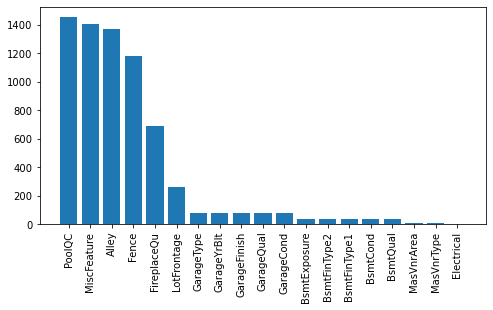

In [3]:
# 觀察缺失值狀況
# 有許多特徵的缺失值數量已經超過了資料總數的一半，但缺失值有時候其意義不單單只是缺失，也代表某些意義
missing = total.isnull().sum(axis = 0)
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending = False)

plt.figure(figsize = (8, 4))
plt.bar(list(missing.index), np.array(missing))
plt.xticks(rotation='vertical')
plt.show()

In [4]:
discrete = total.columns[total.dtypes == 'object']
for item, val in zip(missing.index, missing.values):
    if item in discrete:
        print(f'{item:12} is  discrete.', end = ' ')
    else:
        print(f'{item:12} is continual.', end = ' ')
    print(f'Missing {val / total.shape[0] :.4%}')
# missing

PoolQC       is  discrete. Missing 99.5205%
MiscFeature  is  discrete. Missing 96.3014%
Alley        is  discrete. Missing 93.7671%
Fence        is  discrete. Missing 80.7534%
FireplaceQu  is  discrete. Missing 47.2603%
LotFrontage  is continual. Missing 17.7397%
GarageType   is  discrete. Missing 5.5479%
GarageYrBlt  is continual. Missing 5.5479%
GarageFinish is  discrete. Missing 5.5479%
GarageQual   is  discrete. Missing 5.5479%
GarageCond   is  discrete. Missing 5.5479%
BsmtExposure is  discrete. Missing 2.6027%
BsmtFinType2 is  discrete. Missing 2.6027%
BsmtFinType1 is  discrete. Missing 2.5342%
BsmtCond     is  discrete. Missing 2.5342%
BsmtQual     is  discrete. Missing 2.5342%
MasVnrArea   is continual. Missing 0.5479%
MasVnrType   is  discrete. Missing 0.5479%
Electrical   is  discrete. Missing 0.0685%


In [36]:
total.dtypes == 'object'

Id               False
MSSubClass       False
MSZoning          True
LotFrontage      False
LotArea          False
                 ...  
MoSold           False
YrSold           False
SaleType          True
SaleCondition     True
SalePrice        False
Length: 79, dtype: bool

In [5]:
missing[0]

1453

# Missing value
## 1. PoolQC

In [6]:
def plot_xy(x1, y1, x2, y2):
    plt.figure(figsize = (16, 6), dpi = 70)
    plt.subplot(1, 2, 1, title = 'Train')
    plt.scatter(x1, y1)

    plt.subplot(1, 2, 2, title = 'Test')
    plt.scatter(x2, y2)

    plt.show()

def nan_analysis(feature, target = 'SalePrice', na = 'Na'):
    x1 = train[feature].fillna(na)
    y1 = train[target]
    x2 = test[feature].fillna(na)
    y2 = test[target]
    plot_xy(x1, y1, x2, y2)

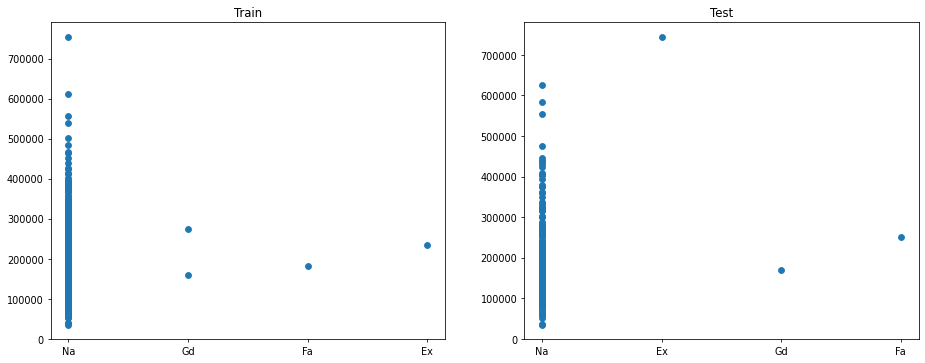

In [7]:
analysis_feature = 'PoolQC'
nan_analysis(analysis_feature)

In [8]:
total.drop(columns = [analysis_feature], inplace = True)

## 2. MiscFeature

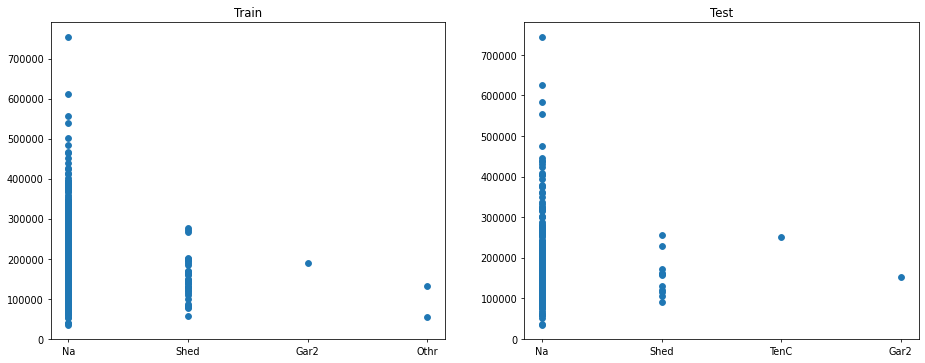

In [9]:
analysis_feature = 'MiscFeature'
nan_analysis(analysis_feature)

In [10]:
total[analysis_feature] = total[analysis_feature].fillna('Na')

## 3. Alley

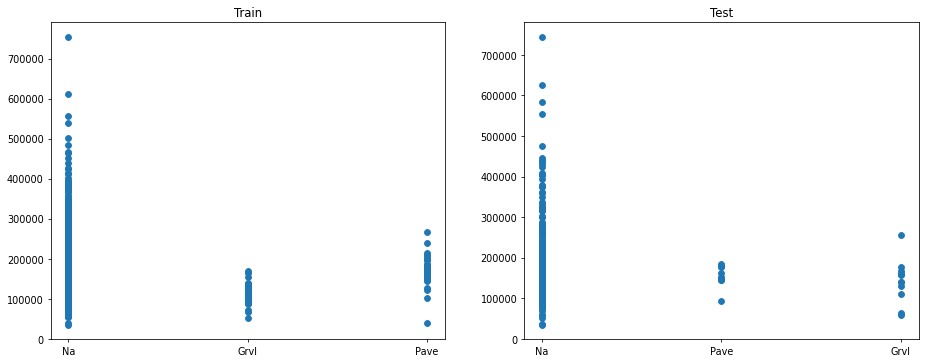

In [11]:
analysis_feature = 'Alley'
nan_analysis(analysis_feature)

In [12]:
total[analysis_feature] = total[analysis_feature].fillna('Na')

## 4. Fence

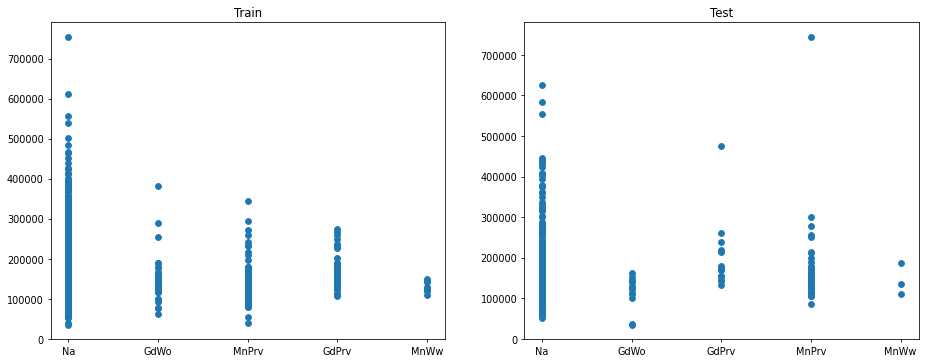

In [13]:
analysis_feature = 'Fence'
nan_analysis(analysis_feature)

In [14]:
total.drop(columns = [analysis_feature], inplace = True)

## 5. FireplaceQu

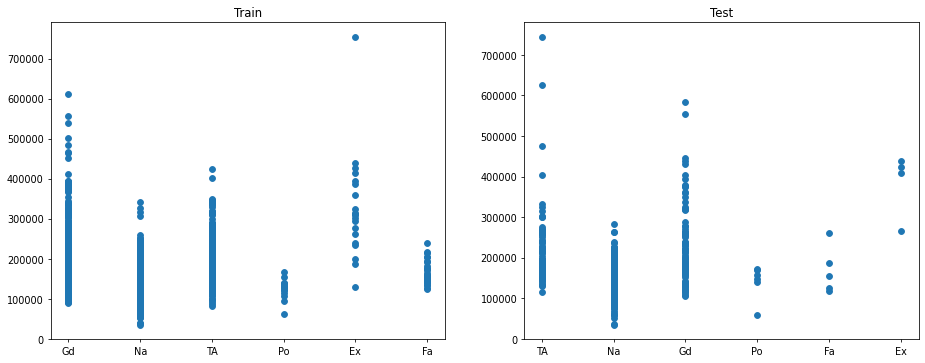

In [15]:
analysis_feature = 'FireplaceQu'
nan_analysis(analysis_feature, na = 'Na')

In [16]:
total[analysis_feature] = total[analysis_feature].fillna('Na')

## 6. LotFrontage

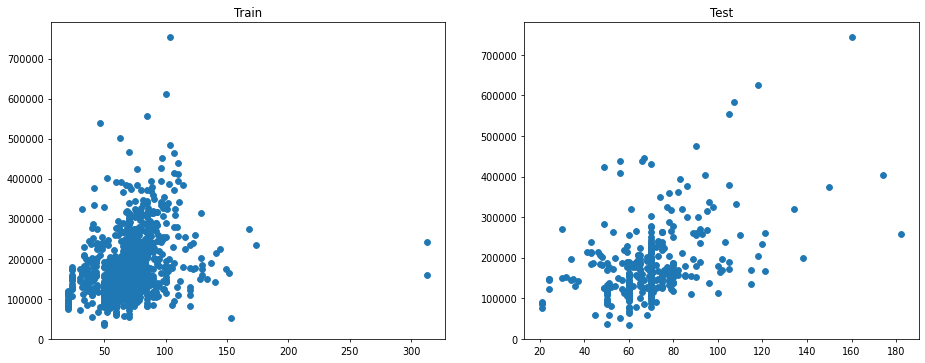

In [17]:
analysis_feature = 'LotFrontage'
nan_analysis(analysis_feature, na = train[analysis_feature].mean())

In [18]:
total[analysis_feature] = total[analysis_feature].fillna(train[analysis_feature].mean())

## 7. The others

BsmtFinType2


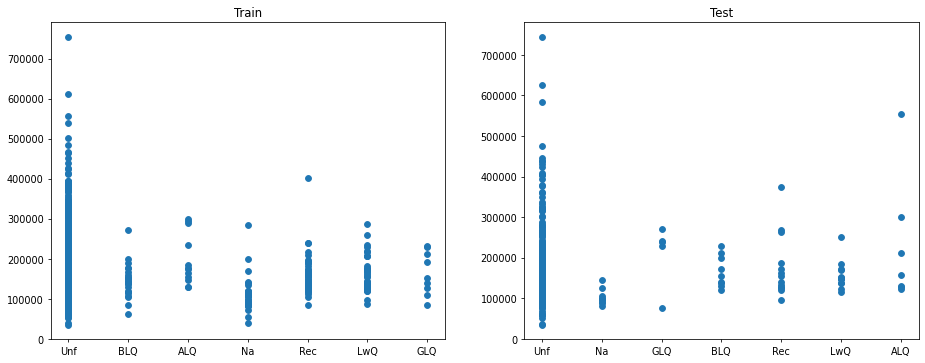

BsmtExposure


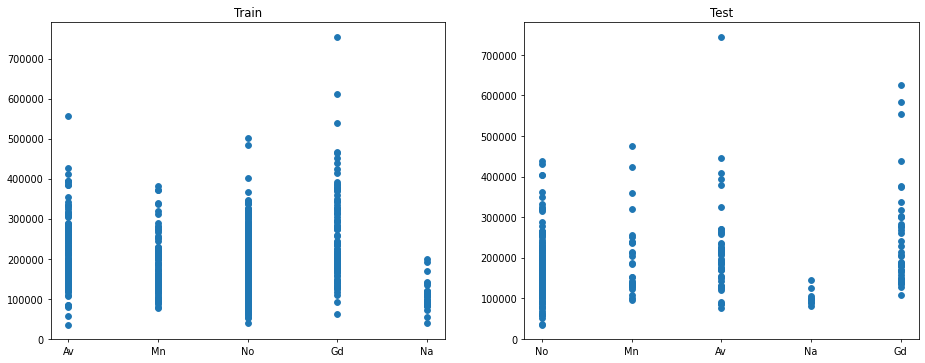

GarageCond


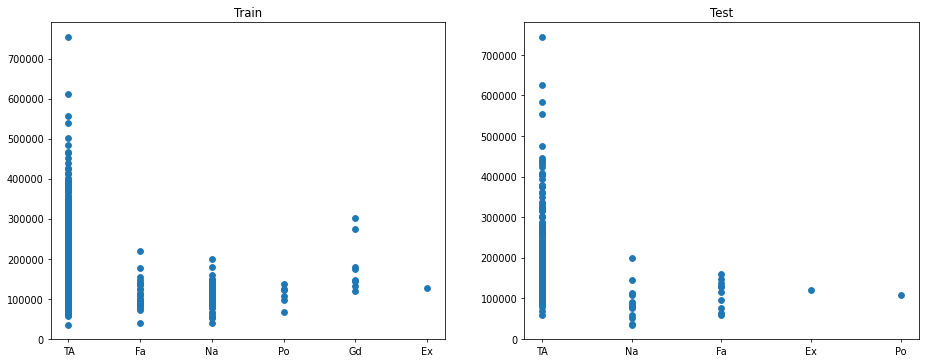

GarageQual


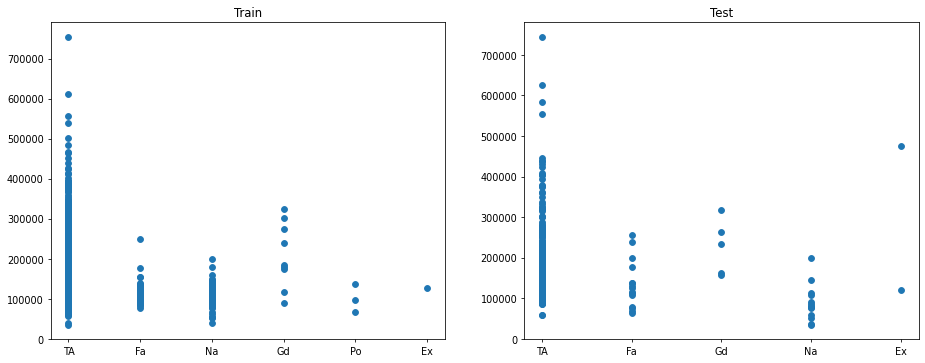

GarageFinish


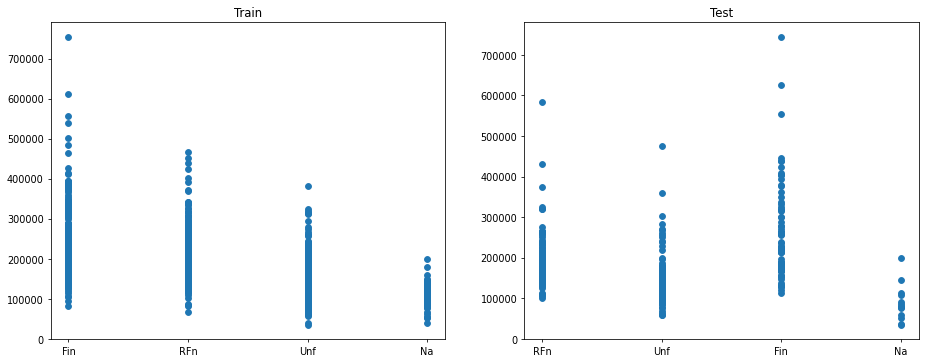

GarageYrBlt


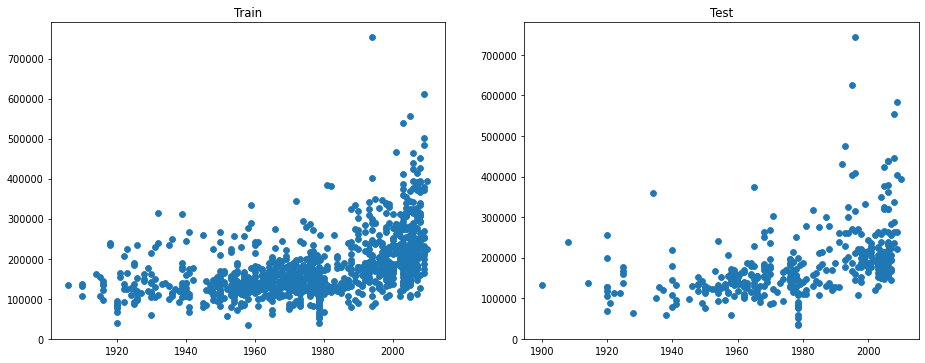

GarageType


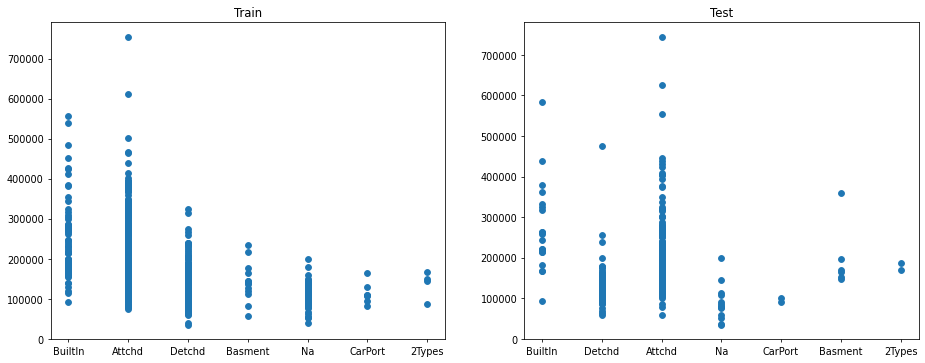

LotFrontage


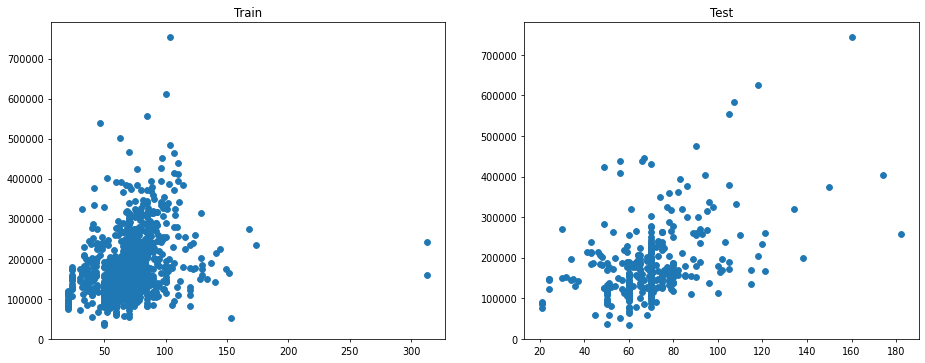

FireplaceQu


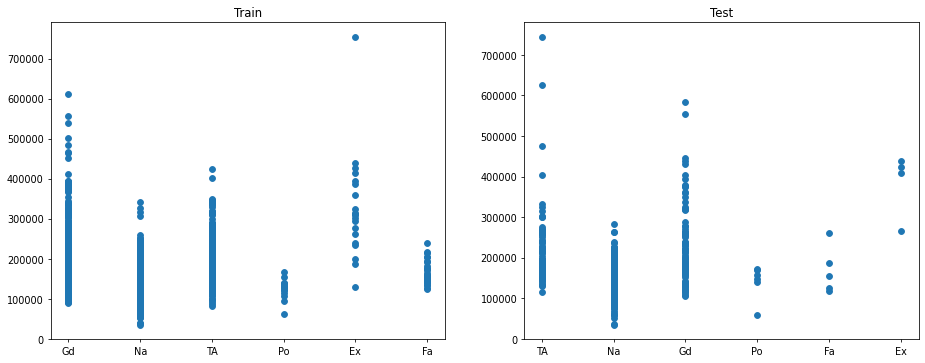

Fence


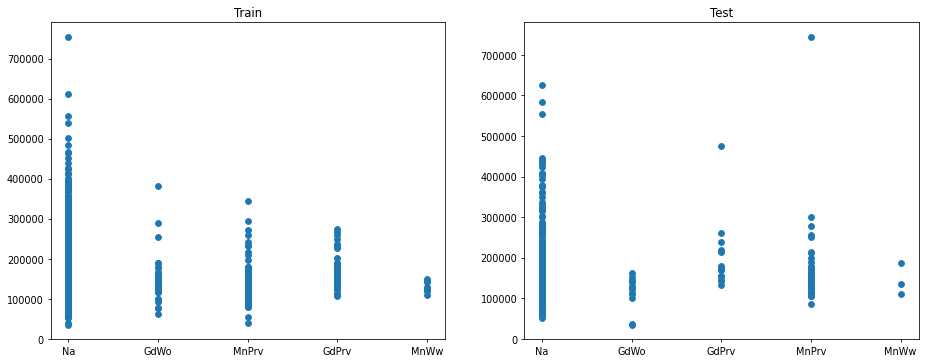

Alley


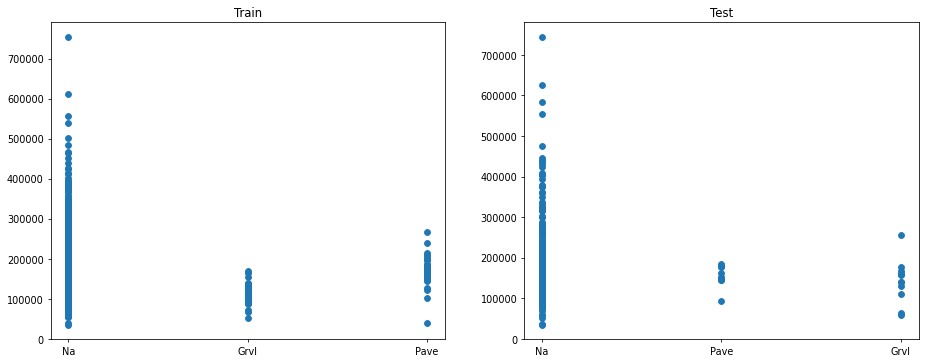

MiscFeature


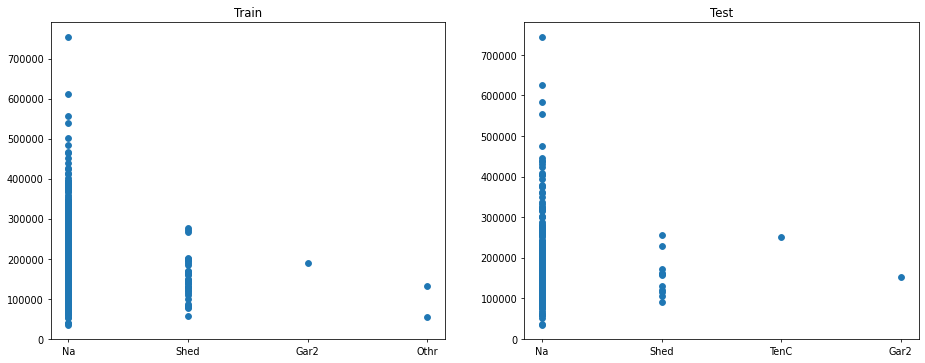

PoolQC


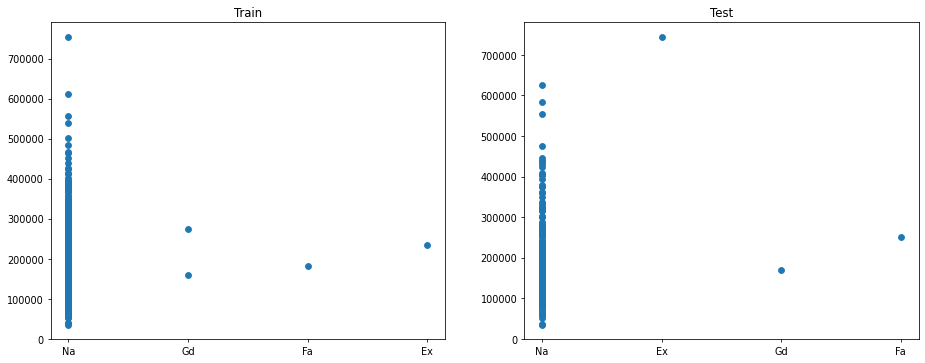

In [21]:
others = missing.index[:-6]
others = others[::-1]
for analysis_feature in others:
    print(analysis_feature)
    if analysis_feature in discrete:
        nan_analysis(analysis_feature)
    else:
        nan_analysis(analysis_feature, na = train[analysis_feature].mean())
        total[analysis_feature] = train[analysis_feature].fillna(train[analysis_feature].mean())

In [22]:
# GarageType
feature = 'GarageType'
mode = train[(train[feature] != 'BuiltIn') & (train[feature] != 'Attchd') & (train[feature] != 'Detchd')][feature].mode()[0]
total[feature] = total[feature].fillna(mode)

In [23]:
# GarageFinish
feature = 'GarageFinish'
total[feature] = total[feature].fillna('Na')

In [24]:
# GarageQual
feature = 'GarageQual'
mode = train[(train[feature] != 'TA')][feature].mode()[0]
total[feature] = total[feature].fillna(mode)

In [25]:
# GarageCond
feature = 'GarageCond'
mode = train[(train[feature] != 'TA')][feature].mode()[0]
total[feature] = total[feature].fillna(mode)

In [26]:
# BsmtFinType2
feature = 'BsmtFinType2'
mode = train[(train[feature] != 'Unf')][feature].mode()[0]
total[feature] = total[feature].fillna(mode)

In [27]:
# BsmtExposure
feature = 'BsmtExposure'
total[feature] = total[feature].fillna('Na')

In [28]:
# BsmtFinType1
feature = 'BsmtFinType1'
total[feature] = total[feature].fillna('Na')

In [29]:
# BsmtCond
feature = 'BsmtCond'
total[feature] = total[feature].fillna('Na')

In [30]:
# BsmtQual
feature = 'BsmtQual'
total[feature] = total[feature].fillna('Na')

In [31]:
# MasVnrType
feature = 'MasVnrType'
total[feature] = total[feature].fillna('BrkCmn')

In [32]:
# Electrical
feature = 'Electrical'
total[feature] = total[feature].fillna('FuseF')

In [33]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 364
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallCo

In [34]:
total.to_csv('total_fillna.csv', index = False)